In [1]:
using Revise
using Random
using Plots  # Optional, for plotting

In [2]:
using PauliPropagation

## Example of using `symmetrypropagate` to propagate a Pauli operator through a circuit

This subsection is included in `test_symmetrymerge.jl`

In [3]:
Random.seed!(42) # for 
nq = 3  # number of qubits
nl = 2  # number of layers
W = Inf;                   # maximal operator weight.
min_abs_coeff = 0;          # neglect small coefficients. Only for numerical and hybrid PP.
thetax, thetaz, thetay = randn(nl), randn(nl), randn(nl)
thetas = theta_periodic_brickwork(nq, nl, thetax, thetaz, thetay);
# Observable to compute the expectation value of:
symbs = [:I for _ in 1:nq]
symbs[round(Integer, nq/2)] = :Z   # as symbol. Also works but is slower.
obsint = symboltoint(symbs);  # for performance we work with bitoperations

In [4]:
# Build single layer of translational invariant brickwork circuit
topo = bricklayertopology(nq, periodic=true)  # periodic boundary conditions
circ_layer = hardwareefficientcircuit(nq, 1; topology=topo)
fastcirc_layer = tofastgates(circ_layer)
thetas_layers = reshape(thetas, :, nl);
symbfs = symmetrypropagate(fastcirc_layer, obsint, thetas_layers, nq, nl, W, min_abs_coeff)
# Compare with numerical propagation
full_circuit = hardwareefficientcircuit(nq, nl; topology=topo)
fastfull_circuit = tofastgates(full_circuit)
numbfs  = mergingbfs(fastfull_circuit, obsint, thetas, max_weight=W, min_abs_coeff=min_abs_coeff);

In [5]:
# Check the expectation value from symmetry propagation and numerical propagation are the same
evsym = evalagainstzero(symbfs) # expectation
evnum = evalagainstzero(numbfs) # expectation
@assert isapprox(evnum, evsym; atol=1e-8) "Numerical value $evnum is not equal to symmetry value $evsym for nq = $nq"
evsym - evnum


1.1102230246251565e-16

## Performance comparison

In [10]:
function compare_numerical_symmetry(qubits, layers)
  times_numerical = Dict()
  times_symmetry = Dict()
  W = Inf;                   # maximal operator weight.
  min_abs_coeff = 0;          # neglect small coefficients. Only for numerical and hybrid PP.
  for nq in qubits
      # Observable to compute the expectation value of:
      symbs = [:I for _ in 1:nq]
      symbs[round(Integer, nq/2)] = :Z   # as symbol. Also works but is slower.
      obsint = symboltoint(symbs)  # for performance we work with bitoperations
      # println("observable string: ", join(symbs))
      for nl in layers
          #YT: currently if topology and nq are not consistent, the code will throw an error.
          # Consider adding a check to make sure topology and nq are compatible. 
          topo = bricklayertopology(nq, periodic=true)  # periodic boundary conditions
          # Build brickwork circuit
          circ = hardwareefficientcircuit(nq, nl; topology=topo)
          fastcirc = tofastgates(circ)
          thetas = theta_periodic_brickwork(nq, nl, randn(nl), randn(nl), randn(nl));
          t_numerical = @timed mergingbfs(fastcirc, obsint, thetas; max_weight=W, min_abs_coeff=min_abs_coeff);
          ev_numerical = evalagainstzero(t_numerical.value)
          # push!(times_numerical, t_numerical.time)
          times_numerical[(nq, nl)] = t_numerical.time

          # Build single layer of translational invariant brickwork circuit
          circ_layer = hardwareefficientcircuit(nq, 1; topology=topo)
          fastcirc_layer = tofastgates(circ_layer)
          thetas_layers = reshape(thetas, :, nl);
          t_symmetry = @timed symmetrypropagate(fastcirc_layer, obsint, thetas_layers, nq, nl, W, min_abs_coeff)
          ev_symmetry = evalagainstzero(t_symmetry.value)
          # push!(times_symmetry, t_symmetry.time)
          times_symmetry[(nq, nl)] = t_symmetry.time

          # Check numerical and symmetry expectation are the same
          @assert isapprox(ev_numerical, ev_symmetry; atol=1e-5) "Numerical value $ev_numerical is not equal to symmetry value $ev_symmetry for nq = $nq"
      end
  end
return times_numerical, times_symmetry
end


compare_numerical_symmetry (generic function with 1 method)

In [18]:
Random.seed!(42) # for reproducibility
layers = [1, 6, 9]
qubits = 5:2:11
times_numerical, times_symmetry = compare_numerical_symmetry(qubits, layers)

(Dict{Any, Any}((7, 1) => 2.9694e-5, (5, 9) => 0.013730218, (5, 6) => 0.012245227, (11, 9) => 162.171856772, (9, 9) => 5.760907362, (5, 1) => 3.7615e-5, (11, 6) => 35.184410538, (7, 9) => 0.270268113, (9, 6) => 2.615630952, (11, 1) => 4.082e-5…), Dict{Any, Any}((7, 1) => 3.993e-5, (5, 9) => 0.012571152, (5, 6) => 0.0102909, (11, 9) => 156.03974455, (9, 9) => 5.282779422, (5, 1) => 3.2488e-5, (11, 6) => 38.490644043, (7, 9) => 0.316315704, (9, 6) => 2.459104976, (11, 1) => 6.0813e-5…))

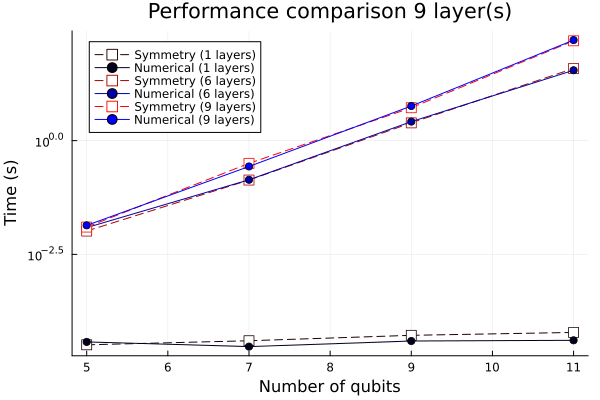

Number of qubits: 5:2:11
Numerical times: Dict{Any, Any}((7, 1) => 2.9694e-5, (5, 9) => 0.013730218, (5, 6) => 0.012245227, (11, 9) => 162.171856772, (9, 9) => 5.760907362, (5, 1) => 3.7615e-5, (11, 6) => 35.184410538, (7, 9) => 0.270268113, (9, 6) => 2.615630952, (11, 1) => 4.082e-5, (7, 6) => 0.137840303, (9, 1) => 3.9407e-5)
Symmetry times: Dict{Any, Any}((7, 1) => 3.993e-5, (5, 9) => 0.012571152, (5, 6) => 0.0102909, (11, 9) => 156.03974455, (9, 9) => 5.282779422, (5, 1) => 3.2488e-5, (11, 6) => 38.490644043, (7, 9) => 0.316315704, (9, 6) => 2.459104976, (11, 1) => 6.0813e-5, (7, 6) => 0.135896461, (9, 1) => 5.2555e-5)


In [19]:

# Print the results
println("Number of qubits: ", qubits)
println("Numerical times: ", times_numerical)
println("Symmetry times: ", times_symmetry)

# Create an empty plot 
Plot = plot()

# Plot the performance as a function of parameter `n`
for d in layers
    times_numerical_n = [times_numerical[(n, d)] for n in qubits]
    times_symmetry_n = [times_symmetry[(n, d)] for n in qubits]
    # Display d in different gradient of color
    colors_numerical = [RGB(0, 0, d/maximum(layers)) for _ in 1:length(qubits)]
    colors_symmetry = [RGB(d/maximum(layers), 0, 0) for _ in 1:length(qubits)]
    

    plot!(
        Plot, qubits, times_symmetry_n, 
        label="Symmetry ($d layers)" ,marker=:square, color=colors_symmetry,
        yscale=:log10, markersize=5,
        markercolor=RGBA(1, 1, 1, 0), markerstrokecolor=colors_symmetry, linestyle=:dash
        # color=colors_symmetry, markercolor=:transparent,
    )
    plot!(Plot, qubits, times_numerical_n, 
        label="Numerical ($d layers)" ,marker=:circle, color=colors_numerical,
        yscale=:log10, 
        xlabel="Number of qubits", ylabel="Time (s)", title="Performance comparison $d layer(s)"
    )
    plot!(Plot, legend=:topleft)
end
display(Plot)